## Import relavent libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.io import loadmat

## Markov 1 Processes
A Markov 1 process can be typically represented by a matrix R with entries $R(i,j) = \rho^{|i-j|}$ where $\rho$ is given.

In [2]:
def create_Markov1_matrix(n,rho):
    R = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            R[i,j] = rho**(np.abs(i-j))
    return R

## Walsh Haddamard Transform
WHT uses the Haddamard matrices that at $N x N$, where $N = 2^n$, n=0,1,2...
These can be generated from a core matrix
\begin{gather}
H_1 =
\begin{bmatrix}
1 & 1\\
1 & -1
\end{bmatrix}
\end{gather}
Subsequent matrices can be generated through a Kronecker product, ie., $H_n = H_1 \otimes H_{n-1}$.

The WHT is applied as $H_x * image * H_y^T$ to obtain the coefficients. $H_x$ and $H_y$ are the Haddamard matrices with the suitable length and width of the image.

In [3]:
def get_Haddamard (n):
    H1 = np.array([[1,1],[1,-1]])
    H1 = np.sqrt(1/2)*H1
    Hn = H1.copy()
    if n!=1:
        for i in range(1,n):
            Hn = np.kron(Hn,H1)
    return Hn

In [4]:
def Walsh_Haddamard_transform(U):
    [x,y] = np.shape(U)
    Hx = get_Haddamard (int(math.log2(x)))
    Hy = get_Haddamard (int(math.log2(y)))
    V = Hx@U@(Hy.T)
    return V

## Discrete Cosine Transform
DCT is performed on a 2D image as $C_x * image * C_y^T$ where $C_x$ and $C_y$ are DCT matrices wrt the length and width of the image. The DCT matrix can be determined as follows:
\begin{gather}
C(k,n) =
\begin{cases}
\frac{1}{\sqrt{N}}, k=0, 0\leq n\leq N-1 \\
\frac{2}{\sqrt{N}} \cos(\frac{\pi(2n+1)k}{2N}), 1\leq k \leq N-1, 0\leq n\leq N-1
\end{cases}
\end{gather}

In [5]:
def get_DCT(N):
    C = np.zeros((N,N))
    for k in range(N):
        for n in range(N):
            if k==0:
                C[k,n] = np.sqrt(1/N)
            else:
                C[k,n] = (np.sqrt(2/N))*(np.cos((math.pi*((2*n)+1)*k)/(2*N)))
    return C

In [6]:
def DCT(U):
    [x,y] = np.shape(U)
    Cx = get_DCT(x)
    Cy = get_DCT(y)
    return Cx@U@(Cy.T)

## Energy Packing Efficiency
The EPE of a transform can be given as $EPE(m) = \frac{\Sigma_{i=1}^{m}R'_{i, i}}{\Sigma_{i=1}^{N}R'_{i, i}}$ where m is the no. of coefficients.

In [7]:
def EPE(R):
    diagonal = np.abs(np.diag(R))
    denominator = np.sum(diagonal)
    numerator = np.cumsum(diagonal)
    return numerator/denominator

## Decorrelation Efficiency
Decorrelation efficiency can be given as $\eta = 1-\frac{\alpha}{\beta}$, where $\alpha = \Sigma_{i,j=1,i\neq j}^{N}|R'_{i, i}|$, $\beta = \Sigma_{i,j=1,i\neq j}^{N}|R_{i, i}|$

In [8]:
def DCE(R,R_prime):
    [x,y]=np.shape(R)
    alpha = 0
    beta = 0
    for i in range(x):
        for j in range(y):
            if(i!=j):
                alpha = alpha + np.abs(R_prime[i,j])
                beta = beta + np.abs(R[i,j])
    eta = 1-alpha/beta
    return eta

## Eigen Values and Eigen Vectors
We compute the eigenvalues and eigenvectors of R. The are ordered. We compare them with the DCT basis.

In [9]:
def Eigen_values(A):
    ev, EV = np.linalg.eig(A)
    idx = ev.argsort()[::-1]
    idx = ev.argsort()[::-1]
    ev = ev[idx]
    EV = EV[:, idx]
    return ev,EV

## Task 1
Assume a Markov-1 process with covariance matrix R of size 8 × 8 and $\rho$ = 0.91. Compute the
Energy Packing Efficiency and De-correlation Efficiency of the Walsh-Haddamard Transform
and Discrete Cosine Transform for the above process. What is your observation about the
eigenvectors of R in relation to the DCT basis?

In [10]:
rho = 0.91
N = 8
R = create_Markov1_matrix(N,rho)
W = Walsh_Haddamard_transform(R)
D = DCT(R)

W_EPE = EPE(W)
W_DCE = DCE(R,W)
D_EPE = EPE(D)
D_DCE = DCE(R,W)

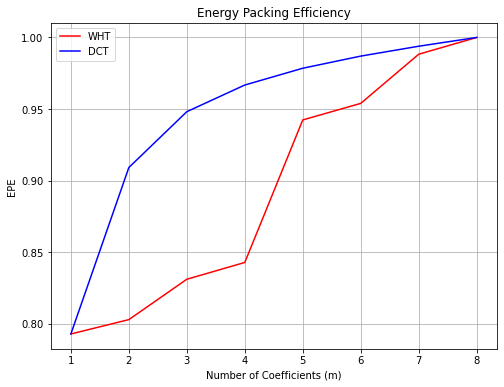

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(N)+1, W_EPE, 'red')
plt.plot(np.arange(N)+1, D_EPE, 'blue')
plt.xlabel("Number of Coefficients (m)")
plt.ylabel("EPE")
plt.title("Energy Packing Efficiency")
plt.legend(["WHT", "DCT"])
plt.grid(True)
plt.show()

In [12]:
[ev,EV] = Eigen_values(R)
DCT_basis = get_DCT(N)

## Triagonal Matrix

In [13]:
def get_Q (alpha,N):
    Q = np.zeros((N,N))
    Q[0,0] = 1 - alpha
    Q[-1,-1] = 1 - alpha
    for i in range(1,N-1):
        Q[i,i] = 1
        Q[i-1,i] = -alpha
        Q[i,i-1] = -alpha
    return Q

## Relationship between R and tridiagonal matrix
$\beta^2R^{-1}$ can be observed to be a tridiagobal matrix where $\beta^2$ is $\frac{1-\rho^2}{1+\rho^2}$ and the value of $\alpha$ in the Q matrix is $\frac{\rho}{1-\rho^2}$

In [14]:
def calc_alpha_beta (rho):
    alpha = rho/(1+rho**2)
    beta = (1-rho**2)/(1+rho**2)
    return alpha,np.sqrt(beta)

In [15]:
[alpha,beta] = calc_alpha_beta(rho)
Q = get_Q(alpha,N)
BR_ = (beta**2)*np.linalg.inv(R)

In [16]:
display(np.round(Q,decimals=3))

array([[ 0.502, -0.498,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.498,  1.   , -0.498,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.498,  1.   , -0.498,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   , -0.498,  1.   , -0.498,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.498,  1.   , -0.498,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   , -0.498,  1.   , -0.498,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.498,  1.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.502]])

In [17]:
display(np.round(BR_,decimals=3))

array([[ 0.547, -0.498,  0.   , -0.   ,  0.   , -0.   ,  0.   , -0.   ],
       [-0.498,  1.   , -0.498,  0.   , -0.   ,  0.   , -0.   ,  0.   ],
       [ 0.   , -0.498,  1.   , -0.498, -0.   ,  0.   ,  0.   , -0.   ],
       [-0.   ,  0.   , -0.498,  1.   , -0.498, -0.   , -0.   ,  0.   ],
       [ 0.   , -0.   ,  0.   , -0.498,  1.   , -0.498,  0.   , -0.   ],
       [-0.   ,  0.   ,  0.   , -0.   , -0.498,  1.   , -0.498,  0.   ],
       [ 0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.498,  1.   , -0.498],
       [-0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   , -0.498,  0.547]])

## Diagonalisation using DCT
We diagonalise Q and $\beta^2R$ using DCT. We observe that both are not diagonalisable

In [18]:
Diagonalized_matrix_1 = DCT(Q)
Diagonalized_matrix_2 = DCT(BR_)

In [19]:
display(np.round(Diagonalized_matrix_1,decimals=3))

array([[ 0.129, -0.159,  0.115, -0.056, -0.   ,  0.037, -0.048,  0.032],
       [-0.159,  0.283, -0.142,  0.062,  0.013, -0.062,  0.073, -0.048],
       [ 0.115, -0.142,  0.384, -0.017, -0.048,  0.086, -0.088,  0.055],
       [-0.056,  0.062, -0.017,  0.579,  0.09 , -0.115,  0.105, -0.062],
       [ 0.   ,  0.013, -0.048,  0.09 ,  0.876,  0.135, -0.115,  0.066],
       [ 0.037, -0.062,  0.086, -0.115,  0.135,  1.245,  0.111, -0.062],
       [-0.048,  0.073, -0.088,  0.105, -0.115,  0.111,  1.616,  0.049],
       [ 0.032, -0.048,  0.055, -0.062,  0.066, -0.062,  0.049,  1.893]])

In [20]:
display(np.round(Diagonalized_matrix_2,decimals=3))

array([[ 0.016,  0.   ,  0.015, -0.   ,  0.011,  0.   ,  0.006,  0.   ],
       [-0.   ,  0.102, -0.   ,  0.018,  0.   ,  0.012,  0.   ,  0.004],
       [ 0.015,  0.   ,  0.315,  0.   ,  0.015,  0.   ,  0.008,  0.   ],
       [-0.   ,  0.018,  0.   ,  0.634,  0.   ,  0.01 ,  0.   ,  0.004],
       [ 0.011,  0.   ,  0.015,  0.   ,  1.011,  0.   ,  0.006, -0.   ],
       [ 0.   ,  0.012,  0.   ,  0.01 ,  0.   ,  1.388, -0.   ,  0.002],
       [ 0.006,  0.   ,  0.008,  0.   ,  0.006, -0.   ,  1.707, -0.   ],
       [ 0.   ,  0.004,  0.   ,  0.004, -0.   ,  0.002, -0.   ,  1.921]])

## Singular Value Decomposition of a 2D image
Compute SVD for the given 8 × 8 image g (provided in imageFile.mat and also given below)
using the following steps:
(a) Perform eigen-value decomposition of $gg^T$ and $g^Tg$
(b) Find the singular value matrix $\Sigma$.
(c) Reconstruct the image using $\Sigma$ and the eigen-vector matrices.

We then follow by trying to reconstruct the image with the highest k eigen values removed and observe $\hat{g}_k$.There reconstruction error can be theoritically given as the Frobenius norm of the error between the image and reconstructed one. As discussed in class, this is the sum of the k $\sigma$ values.

In [21]:
def SVD(g):
    g = g.astype(np.float64)
    m, n = np.shape(g)
    min_dim = min(m, n)
    sigma = np.zeros((m, n))
    S1 = g@(g.T)
    S2 = (g.T)@g
    e1, v1 = Eigen_values(S1)
    e2, v2 = Eigen_values(S2)
    for i in range(min_dim):
        sigma[i, i] = (np.sqrt(e1[i])+np.sqrt(e2[i]))/2
        v = v2[:, i]
        if np.sum((g@v-sigma[i, i]*v1[:, i])**2) > np.sum((g@v+sigma[i, i]*v1[:, i])**2):
            v2[:, i] = -v
    return v1, sigma, v2

In [22]:
def reconstruct_from_SVD(A, Sigma, B):
    return A@Sigma@(B.T)

In [23]:
def reconstruction_errors_SVD(g, A, Sigma, B):
    g = g.astype(np.float64)
    m, n = np.shape(g)
    min_dim = min(m, n)
    reconstruction_errors = np.zeros(min_dim)
    reconstructed_matrix = g.copy()
    for i in range(min_dim):
        # remove the contribution of the ith singular value and its vectors
        reconstructed_matrix -= Sigma[i, i]*np.outer(A[:, i], B[:, i])
        # get the frobenius norm
        reconstruction_errors[i] = np.sum((reconstructed_matrix - g)**2)
    return reconstruction_errors

In [24]:
def theoretical_reconstruction_errors(Sigma):
    # get the non zero entries of the Sigma matrix
    sigma = Sigma[Sigma > 0]
    return np.cumsum(sigma**2)

In [25]:
g = loadmat('imageFile.mat')['g']
A, Sigma, B = SVD(g)
# reconstruct g using all singular values
g_hat = reconstruct_from_SVD(A, Sigma, B)
# get the theoretical and experimental reconstruction errors
reconstruction_errors_experimental = reconstruction_errors_SVD(g, A, Sigma, B)
reconstruction_errors_theoretical = theoretical_reconstruction_errors(Sigma)

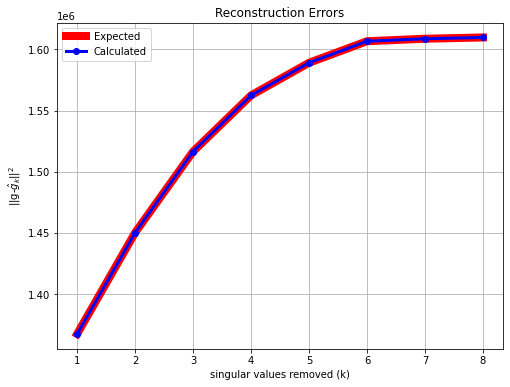

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(N)+1, reconstruction_errors_theoretical, 'red', linewidth=8)
plt.plot(np.arange(N)+1, reconstruction_errors_experimental,
         '-o', linewidth=3, color="blue")
plt.xlabel("singular values removed (k)")
plt.ylabel(r'||g-$\hat{g}_{k}||^{2}$')
plt.legend(["Expected", "Calculated"])
plt.title("Reconstruction Errors")
plt.grid(True)
plt.show()